# Underway quick look at files

Load the data and make some plots and stuff using `kval`'s built-in functionality (basic stuff for now).

In [94]:
# Load the ctd module from the kval library  
from kval.data import ctd
import glob2

# for data manipualtion
import pandas as pd
import xarray as xr
import numpy as np

# for custom plotting
import matplotlib.pyplot as plt
# Set the matplotlib backend so we can interact with the plots (zoom, click buttons etc)
%matplotlib widget

## Load data from `.cnv`s

In [96]:
# Get a list of the processed CTD-data files
cnv_list_all = glob2.glob('../../../../proc/*.cnv')

# Get lists of binne and unbinned data, respectively
cnv_list_bin = [file for file in cnv_list_all if '_bin' in file]
cnv_list_nbin = [file for file in cnv_list_all if not  '_bin' in file]

In [97]:
# Load the CTD data as joined xarray dataset
# ds = ctd.ctds_from_cnv_dir('../../../../proc/')
ds_ctd = ctd.ctds_from_cnv_list(cnv_list_bin, station_from_filename=False)

# manually fix station name (string entered when starting the data recording, should have been statio number only)
ds_ctd.STATION[2] = '83'
ds_ctd.STATION[3] = '84'

NOTE!: 72: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 74: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0083: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: stnr0084: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 95: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 106: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 113: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 118: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 127: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 132: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: 133: Unable to find [latitude, longitude] in .cnv file --> Assigning NaN values.
NOTE!: * Station:: Unable

Joining profiles together:   0%|          | 0/12 [00:00<?, ?it/s]

In [98]:
print(ds_ctd)

<xarray.Dataset> Size: 252kB
Dimensions:      (TIME: 12, PRES: 323)
Coordinates:
  * PRES         (PRES) float64 3kB 2.0 3.0 4.0 5.0 ... 322.0 323.0 324.0 325.0
  * TIME         (TIME) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
Data variables: (12/13)
    TEMP1        (TIME, PRES) float64 31kB nan nan nan 5.123 ... nan nan nan nan
    CNDC1        (TIME, PRES) float64 31kB nan nan nan 3.106 ... nan nan nan nan
    flSP         (TIME, PRES) float64 31kB nan nan nan 0.4117 ... nan nan nan
    PSAL1        (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_saA0     (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    gsw_ctA0     (TIME, PRES) float64 31kB nan nan nan nan ... nan nan nan nan
    ...           ...
    TIME_SAMPLE  (TIME, PRES) float64 31kB nan nan nan 1.984e+04 ... nan nan nan
    STATION      (TIME) <U10 480B '* Station:' '72' '83' ... '127' '132' '133'
    LATITUDE     (TIME) float64 96B nan nan nan nan nan ... nan nan nan nan 

In [99]:
# load logsheet into pandas data frame for meta data; later used for coordinate matching of the stations and bottle value avearging
df_log = pd.read_excel('../../../../logsheets/iC3_field_school_samplelog_marine_clean.xlsx', sheet_name='samplelog')[
    ['decimalLatitude', 'decimalLongitude', 'bottomDepthInMeters', 'locationID', 'gearType', 'niskinNumber', 'maximumDepthInMeters','sampleType']]

# extract numerical StationID from locatioID string using regexp
df_log['STATION'] = df_log.locationID.str.extract('(^\d*)')

# extract geographical coordinates logsheet data frame; remove duplicates & swap dimensions
df_loc_all = df_log.drop_duplicates(subset=['decimalLatitude', 'decimalLongitude', 'STATION']).dropna(subset=['decimalLatitude'])
df_loc = df_loc_all[['STATION', 'decimalLatitude', 'decimalLongitude']]
# convert location data frame into dataset and insert values into cnv dataset
ds_loc = xr.Dataset(df_loc)
ds_loc = ds_loc.swap_dims({'dim_0': 'STATION'})

# Make `STATION` a coordinate in the CTD dataset for combining with position data.
ds_ctd = ds_ctd.swap_dims({'TIME': 'STATION'})
ds_ctd['LATITUDE']=ds_loc.decimalLatitude
ds_ctd['LONGITUDE']=ds_loc.decimalLongitude

# swap coordinates back for use with plotting fucntions in kval
ds_ctd = ds_ctd.swap_dims({'STATION':'TIME'})

C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [100]:
# Do some standard tweaks to metadata (not necessarily ideal formatting)
ds_ctd = ctd.metadata_auto(ds_ctd)

#### Look at the file 

Click-browse through variables and attributes to see that everything looks good.

## Quick looks
Note: Good practice to close the plots when you are done. Otherwise, they still take up memory.

#### Look at profile locations on a map

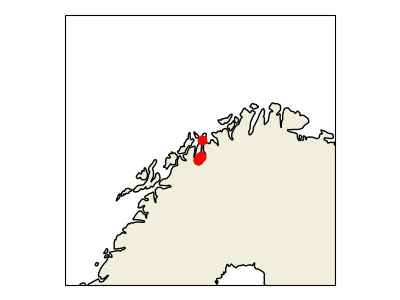

In [101]:
ctd.map(ds_ctd)

#### Look at some contours of the data

Use the interactive functionality to look through variables etc.

In [102]:
ctd.contour(ds_ctd)

#### Inspect individual profiles

In [103]:
ctd.inspect_profiles(ds_ctd)

There is a weird spike to low salinities in profile 8. That one should be corrected manually.

Now, let's make your own T-S diagram for water mass identification

For more fancy stuff, explore: https://xoa.readthedocs.io/en/develop/api/xoa.plot.plot_ts.html from https://xoa.readthedocs.io

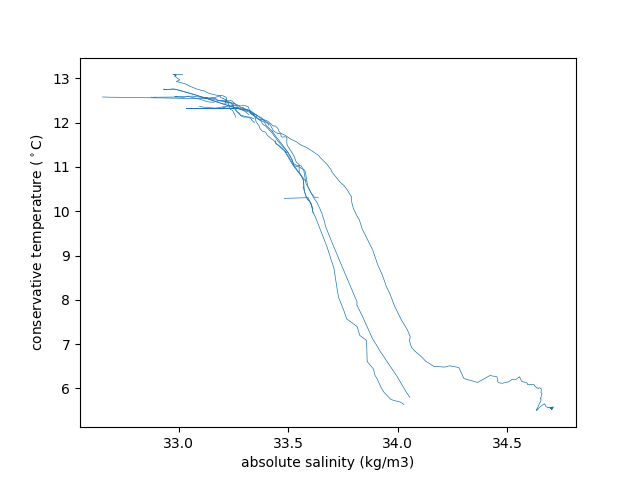

In [104]:
fig, ax = plt.subplots()

# Plot all profiles on to p of each other
for nn in np.arange(ds_ctd.sizes['TIME']):
    x = ds_ctd['gsw_saA'].isel(TIME=nn, drop=True).squeeze()
    y = ds_ctd['gsw_ctA'].isel(TIME=nn, drop=True).squeeze()
    ax.plot(x, y, color='tab:blue', lw=0.5, alpha=1)

ax.set_xlabel('absolute salinity (kg/m3)')
ax.set_ylabel('conservative temperature ($^\circ$C)')

plt.show()

### Export to .netcdf and .mat format

Next we export the data to commonly used netcdf format. Note that we haven't really applied any post-processing steps, just joined the profiles and added some metadata. Since no quality control/ processing has been applied yet, we use a preliminary filename (unprocessed). Use the "Editing.ipynb" notebook to read the netcdf fiel and further process the data.  In case it is useful the dataset can also be exported for analysis in Matlab.

In [105]:
cruise_ctd_id = 'iC3-24-3-BP'
ds_ctd.attrs['id'] = cruise_ctd_id

nc_initial_dir = '../../../../netcdf'
ctd.to_netcdf(ds_ctd, nc_initial_dir, file_name = f'{cruise_ctd_id}_unprocessed')

Updated history attribute. Current content:
---
2024-04-24 to 2024-09-13: Data collection.
2024-09-11 to 2024-09-13: Processed to .cnv using SBE software (details in "PROCESSING.SBE_processing").
2024-09-27: Post-processing.
2024-09-27: Creation of this netcdf file.
---


The file ..\..\..\..\netcdf\iC3-24-3-BP_unprocessed.nc already exists. Do you want to overwrite it? (y/n):  y


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: '..\\..\\..\\..\\netcdf\\iC3-24-3-BP_unprocessed.nc'

### Check the NetCDF
Load the nc file we just created and inspect it.

In [106]:
ds_load = ctd.from_netcdf('../../../../netcdf/' + f'{cruise_ctd_id}_unprocessed.nc')

In [107]:
mat_dir = '../../../../mat/'
ctd.to_mat(ds_ctd, mat_dir + 'ctd_data_unprocessed', simplify = True)

Dropped these variables from the Dataset: PROCESSING.
Saved the (simplified) Dataset to: ../../../../mat/ctd_data_unprocessed.mat


## Compute Bottle averages

Somewhere should also be a block of code to extract bottle averages

Probably, it also makes sense to fill in upper part of profile 10 with data from profile 9, as these are taken at the same location shortly after each other.

In [108]:
############# FIXME:
# Add bottle value averaging here: use logsheet dataframe to extract bottle depths, extract averages 


In [109]:
#Dropping non float type variables to make values be possible to calculate with
ds_ctd = ds_ctd.drop_vars(["CRUISE"])

In [110]:
#Indexing of the ctd dataset for the different bottle depths using pressure 

#from log: 2, 10 (not 72), 20, 40 (74, 118, 127, 133), 50 (not 95, 106, 113, 118, 127, 133), bottom-10

#df_log
#bottom_minus10 = 'bottomDepthInMeters' - 10 = 'maximumDepthInMeters'

#PRES 

#PSAL1.sel(PRES="2")

ds_bottle2 = ds_ctd.loc[dict(PRES="2")]
ds_bottle10 = ds_ctd.loc[dict(PRES="10")]
ds_bottle20 = ds_ctd.loc[dict(PRES="20")]
ds_bottle40 = ds_ctd.loc[dict(PRES="40")]
ds_bottle50 = ds_ctd.loc[dict(PRES="50")]

In [111]:
print(ds_bottle2)

<xarray.Dataset> Size: 2kB
Dimensions:      (TIME: 12)
Coordinates:
    STATION      (TIME) <U10 480B '* Station:' '72' '83' ... '127' '132' '133'
    PRES         float64 8B 2.0
  * TIME         (TIME) float64 96B 1.984e+04 1.998e+04 ... 1.998e+04 1.998e+04
    dim_0        (TIME) float64 96B nan 0.0 66.0 nan ... 205.0 242.0 nan 279.0
Data variables:
    TEMP         (TIME) float64 96B nan 13.05 12.53 12.71 ... nan nan nan nan
    CNDC         (TIME) float64 96B nan 3.876 3.814 3.836 ... nan nan nan nan
    flSP         (TIME) float64 96B nan 0.1764 0.2645 0.1428 ... nan nan nan nan
    PSAL         (TIME) float64 96B nan 32.86 32.72 32.78 ... nan nan nan nan
    gsw_saA      (TIME) float64 96B nan 33.02 32.87 32.93 ... nan nan nan nan
    gsw_ctA      (TIME) float64 96B nan 13.08 12.57 12.75 ... nan nan nan nan
    SBE_FLAG     (TIME) float64 96B nan 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    TIME_SAMPLE  (TIME) float64 96B nan 1.998e+04 1.998e+04 ... nan nan nan
    LATITUDE     (T

In [112]:
#averages at CTD bottle depths
ds_avB2 = ds_bottle2.mean()
ds_avB10 = ds_bottle10.mean()
ds_avB20 = ds_bottle20.mean()
ds_avB40 = ds_bottle40.mean()
ds_avB50 = ds_bottle50.mean()

C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in scalar divide
  data = data / (valid_count - ddof)
C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in scalar divide
  data = data / (valid_count - ddof)
C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in scalar divide
  data = data / (valid_count - ddof)
C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in scalar divide
  data = data / (valid_count - ddof)
C:\Users\rirun2565\AppData\Local\miniforge3\envs\kval_ctd\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in scalar divide
  data = data / (valid_count - ddof)


In [113]:
#read out of results for bottle averages
print(ds_avB2)

<xarray.Dataset> Size: 96B
Dimensions:      ()
Coordinates:
    PRES         float64 8B 2.0
Data variables:
    TEMP         float64 8B 12.71
    CNDC         float64 8B 3.84
    flSP         float64 8B 0.176
    PSAL         float64 8B 32.82
    gsw_saA      float64 8B 32.97
    gsw_ctA      float64 8B 12.75
    SBE_FLAG     float64 8B 0.0
    TIME_SAMPLE  float64 8B 1.998e+04
    LATITUDE     float64 8B 69.48
    LONGITUDE    float64 8B 20.18
    PROCESSING   float64 8B nan
